### TODO

- [x] Initial code
- [x] Run Monte-Carlo, check criteria
- [ ] Add theory, formulas
- [ ] Explain how it works
- [ ] Compare to classic ttest 

In [1]:
from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults', 
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound'])

In [8]:
def relative_ttest(control, test, axis=0, alpha=0.05):
    """ Student's T test for relative difference with confidence interval for two sided hypotesis"""
    
    # Sample means
    mean_control = np.mean(control, axis=axis)
    mean_test = np.mean(test, axis=axis)
    
    # Variance of means for given sample size
    var_mean_control  = np.var(control, axis=axis) / np.shape(control)[axis]
    var_mean_test  = np.var(test, axis=axis) / np.shape(test)[axis]
    
    # Differences
    difference_mean = mean_test - mean_control
    difference_sem  = var_mean_test + var_mean_control
    relative_mu = difference_mean / mean_control
 
    # Taylor's series to get corrent variance estimation for relative difference
    covariance = -var_mean_control
    relative_var =  difference_sem / (mean_control ** 2) \
                    + ((difference_mean ** 2)  / (mean_control ** 4)) * var_mean_control \
                    - 2 * (difference_mean / (mean_control ** 3)) * covariance
    
    # Convert to array if 1 dim for consistency
    relative_mu, relative_var = (np.array(i, ndmin=1) for i in (relative_mu, relative_var))
    
    # Mean difference distribution
    distr_params = zip(relative_mu, relative_var)
    distrs = np.array([sps.norm(loc=mu, scale=np.sqrt(var)) for mu, var in distr_params])
    
    # Results
    bounds = np.array([distr.ppf([alpha/2, 1 - alpha/2]) for distr in distrs])
    ci_lengths = np.array([bound[1] - bound[0] for bound in bounds])
    pvalues = np.array([2 * min(distr.cdf(0), distr.sf(0)) for distr in  distrs])
    
    RelTtest_indResult = namedtuple('RelTtest_indResult', 
                                        ['pvalue', 'effect', 'ci_length', 'bounds'])
    
    return RelTtest_indResult(pvalues, relative_mu, ci_lengths, bounds)

In [9]:
# 1 dim test
control = sps.expon().rvs(1000)
test = sps.expon().rvs(1000)

relative_ttest(control, test)

RelTtest_indResult(pvalue=array([0.5128006]), effect=array([0.03094508]), ci_length=array([0.18534088]), bounds=array([[-0.06172536,  0.12361552]]))

In [10]:
# Several dim test
control = sps.expon().rvs([1000 , 3])
test = sps.expon().rvs([1000 , 3])

relative_ttest(control, test)

RelTtest_indResult(pvalue=array([0.87313754, 0.90699332, 0.41957797]), effect=array([ 0.00725543, -0.0053411 ,  0.03626827]), ci_length=array([0.17811716, 0.17920385, 0.17613625]), bounds=array([[-0.08180315,  0.09631401],
       [-0.09494302,  0.08426083],
       [-0.05179985,  0.1243364 ]]))

In [11]:
def check_for_ttest_applicability(distribution, sample_size, stat_test, iters=int(1e4)):
    """Simple AA test MonteCarlo with Students Test"""
    # Generate samples
    control = distribution.rvs([sample_size, iters])
    test = distribution.rvs([sample_size, iters])
    control_sample_means = np.mean(control, axis=0)
    
    # FPR for t test check
    false_positives= np.sum(stat_test(test, control).pvalue <= 0.05)
    false_positive_rate = false_positives / iters
    ci_fpr = proportion_confint(false_positives, nobs=iters, method='wilson')
    
    # Results: 
    print(f"\n\nFalse Positive Rate for T-test = {false_positive_rate}, with CI {ci_fpr}\n\n")
    sns.displot(data=control[0])
    sns.displot(control_sample_means, color='orange') 



False Positive Rate for T-test = 0.0508, with CI (0.04666599590665271, 0.05527898822956312)




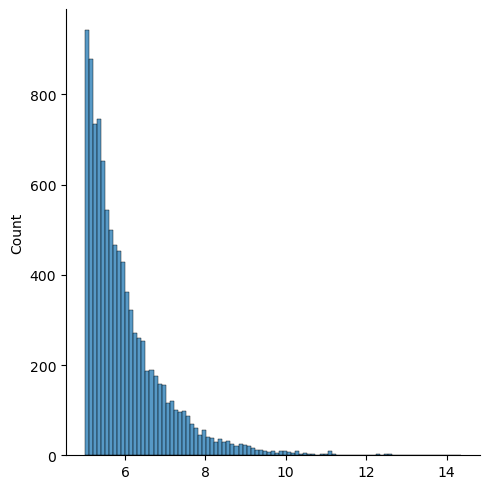

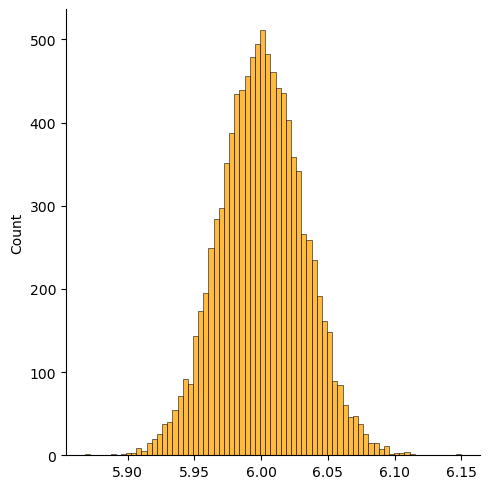

In [ ]:
distribution, sample_size = sps.expon(5), 1000

check_for_ttest_applicability(distribution, sample_size, relative_ttest)

In [2]:
N, NN = int(1e4), int(1e4)

mu_0 = 1
mu_1 = 100

sampling_distr_0 = np.mean(sps.expon(mu_0).rvs(N * NN).reshape(N, NN), axis=1)
sampling_distr_1 = np.mean(sps.expon(mu_1).rvs(N * NN).reshape(N, NN), axis=1)
mean_diff_distr = (sampling_distr_0 - sampling_distr_1) / (mu_1 + 1)
relative_mean_distr = ((sampling_distr_0 - sampling_distr_1) / sampling_distr_1) 

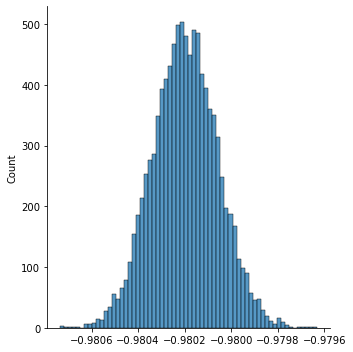

In [3]:
sns.displot(mean_diff_distr)

In [4]:
f_l, f_r = np.percentile(mean_diff_distr, [5, 95]) 
print(f_l, f_r, f_r - f_l)

-0.9804215870724099 -0.979968560008202 0.0004530270642079115


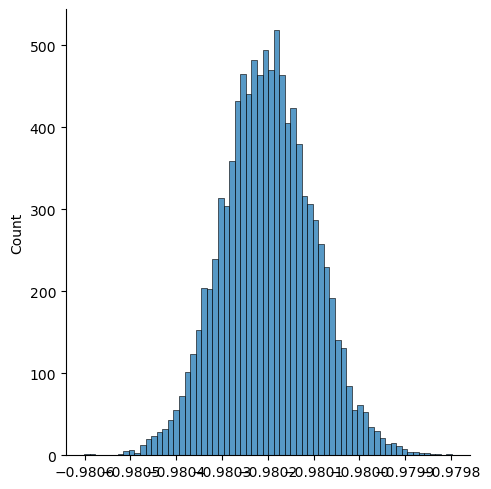

In [5]:
sns.displot(relative_mean_distr)

In [6]:
t_l, t_r = np.percentile(relative_mean_distr, [5, 95]) 
print(t_l, t_r, t_r-t_l)

-0.9803595901545359 -0.9800379696596846 0.0003216204948512935


In [7]:
(t_r-t_l) / (f_r - f_l)

0.7099366026037013

In [116]:
def absolute_ttest(control, test):
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    
    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = sps.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([0.025, 0.975])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)


In [117]:
# 2. Создание тестируемого критерия
def relative_ttest(control, test):
    mean_control = np.mean(control)
    var_mean_control  = np.var(control) / len(control)

    difference_mean = np.mean(test) - mean_control
    difference_mean_var  = np.var(test) / len(test) + var_mean_control
    
    covariance = -var_mean_control

    relative_mu = difference_mean / mean_control
    relative_var = difference_mean_var / (mean_control ** 2) \
                    + var_mean_control * ((difference_mean ** 2) / (mean_control ** 4))\
                    - 2 * (difference_mean / (mean_control ** 3)) * covariance
    relative_distribution = sps.norm(loc=relative_mu, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([0.025, 0.975])
    
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    effect = relative_mu
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)

In [127]:
absolute_power_cnt = 0
relative_power_cnt = 0

# 4. Цикл проверки.
NN = 10000
for i in tqdm_notebook(range(NN)):
    X = sps.expon(1).rvs(N)
    Y = sps.expon(1).rvs(N) * 1.025

    _, _, _, rel_left_bound, rel_right_bound = relative_ttest(X, Y)
    _, _, _, abs_left_bound, abs_right_bound = absolute_ttest(X, Y)
    
    if rel_left_bound > 0:
        relative_power_cnt += 1
    
    if abs_left_bound > 0:
        absolute_power_cnt += 1

print(f"Мощность относительного критрерия VS мощность абсолютного критерия: {relative_power_cnt / N} VS. {absolute_power_cnt /N}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Мощность относительного критрерия VS мощность абсолютного критерия: 0.9378 VS. 0.9389
